#### Team Members:
- Akshay Santoshi : CS21BTECH11012
- Nitya Bhamidipaty : CS21BTECH11041

### Fraud Analytics - Assignment 1

In [1]:
import numpy as np
import pregel
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the Excel file
payments_df = pd.read_excel('Payments.xlsx')
bad_nodes_df = pd.read_excel('bad_sender.xlsx')


# Extract columns into separate lists
sender_list = payments_df['Sender'].astype(int).tolist()
receiver_list = payments_df['Receiver'].astype(int).tolist()
amount_list = payments_df['Amount'].astype(int).tolist()
bad_sender_list = bad_nodes_df['Bad Sender'].astype(int).tolist()

In [3]:
nodes_list = list(set(sender_list + receiver_list + bad_sender_list)) # Get unique nodes

outgoing_edges = {}

# Replaced multiple directed edges from a node to another anoder node with single directed edge with amounts added
for sender, receiver, amount in zip(sender_list, receiver_list, amount_list):
    if sender not in outgoing_edges:
        outgoing_edges[sender] = []
    found = False
    for i, (recv, amt) in enumerate(outgoing_edges[sender]):
        if recv == receiver:
            outgoing_edges[sender][i] = (recv, amt + amount)
            found = True
            break
    if not found:
        outgoing_edges[sender].append((receiver, amount))

In [4]:
class TrustRankVertex(pregel.Vertex):
    
    def __init__(self, vertex_id, bad_sender_list, outgoing_edges, vertex_objs, damping_factor=0.85, max_iterations=50):
        
        out_vertices = []
        if vertex_id in outgoing_edges:
            out_vertices = outgoing_edges[vertex_id]
        
        super().__init__(vertex_id, 0, list(out_vertices))

        self.damping_factor = damping_factor
        self.max_iterations = max_iterations
        if vertex_id in outgoing_edges:
            self.outgoing_edges = outgoing_edges[vertex_id]
        else:
            self.outgoing_edges = []

        if vertex_id in bad_sender_list:
            self.bad_node = True
            self.value = 1/len(bad_sender_list)
        else:
            self.bad_node = False
            self.value = 0

        self.out_deg = 0

        self.out_deg = sum(amount for _, amount in out_vertices)
            
        self.const_value = self.value
        self.vertex_objs = vertex_objs

    def update(self):
        if self.superstep < self.max_iterations:
            
            self.value = (1-self.damping_factor) * self.const_value + self.damping_factor* sum([trustrank for (vertex,trustrank) in self.incoming_messages])
            if self.out_deg != 0:
                self.outgoing_messages = [(self.vertex_objs[id], self.value * amount/ self.out_deg) for id, amount in self.out_vertices]
            else:
                self.outgoing_messages = []
        else:
            # stop after max_iterations supersteps
            self.active = False

In [5]:
# Creating vertex objects
vertices = []
vertex_objs = {}
for node_id in nodes_list:
    if node_id in vertex_objs:
        vertices.append(vertex_objs[node_id])
    else:
        vertex_objs[node_id] = TrustRankVertex(node_id, bad_sender_list, outgoing_edges, vertex_objs, 0.85, 50)
        vertices.append(vertex_objs[node_id])

In [6]:
# Run the Pregel algorithm
Pregel = pregel.Pregel(vertices, 4)
Pregel.run()


In [7]:
# Print the trust values
trust_values = []
df = {'Node': [], 'Trust Value': []}
for vertex in Pregel.vertices:
    print(vertex.id, vertex.value)
    trust_values.append(vertex.value) # for plotting
    df['Node'].append(vertex.id)
    df['Trust Value'].append(vertex.value)
    if vertex.id not in bad_sender_list and vertex.value > 0.0:
        print("New Bad Sender: ", vertex.id, "Trust Value: ", vertex.value)

# Save the trust values to an Excel file
df = pd.DataFrame(df)
df.to_excel('TrustValuesResults.xlsx', index=False)

2050 0.0
2052 0.0
2053 0.0
2054 0.0
2057 0.0
2060 0.0
2061 0.0
2062 0.0
2066 0.0
2071 0.0
2072 0.0
2073 0.0
2075 0.0
2076 0.0
2078 0.0
2080 0.0
2081 0.0
2084 0.0
2085 0.0
2088 0.0
2089 0.0
2090 0.0
2093 0.0
2097 0.0
2100 0.0
2101 0.0
2104 0.0
2107 0.0
2108 0.0
2109 0.0
2111 0.0
2124 0.0
2126 0.0
2127 0.0
2136 0.0
2137 0.0
2142 0.0
2145 0.0
2146 0.0
2150 0.0
2151 0.0
2152 0.0
2158 0.0
2162 0.0
2164 0.0
2166 0.0
2168 0.0
2169 0.0
2170 0.0
2171 0.0
2172 0.0
2174 0.0
2177 0.0
2182 0.0
2184 0.0
2188 0.0
2189 0.0
2190 0.0
1001 0.0014958162735442745
New Bad Sender:  1001 Trust Value:  0.0014958162735442745
1002 0.0001183049489287393
New Bad Sender:  1002 Trust Value:  0.0001183049489287393
1003 0.0002616960104011364
New Bad Sender:  1003 Trust Value:  0.0002616960104011364
1004 0.0027876223282081915
New Bad Sender:  1004 Trust Value:  0.0027876223282081915
1005 0.0065028619979916324
New Bad Sender:  1005 Trust Value:  0.0065028619979916324
1006 0.0006341586853778971
New Bad Sender:  1006 Trus

In [8]:
for bad_sender in bad_sender_list: # Print the trust value of bad senders 
    print(bad_sender, vertex_objs[bad_sender].value)

1303 0.0075000000000000015
1259 0.0075000000000000015
1562 0.0075000000000000015
1147 0.010154988749819452
1393 0.0075000000000000015
1031 0.0075000000000000015
1210 0.021492828473745243
1042 0.01679580245638882
1048 0.01080176166320239
1256 0.0075000000000000015
1668 0.0075000000000000015
1161 0.007731886578835433
1007 0.028530440071183258
1034 0.012843563739028587
1836 0.007531698596705518
1099 0.010594430450201161
1489 0.007564768191146335
1821 0.0075000000000000015
1076 0.011995184717713013
1944 0.0075000000000000015


- Note that bad senders are getting higher fraud value. So th results are align with the actual data.

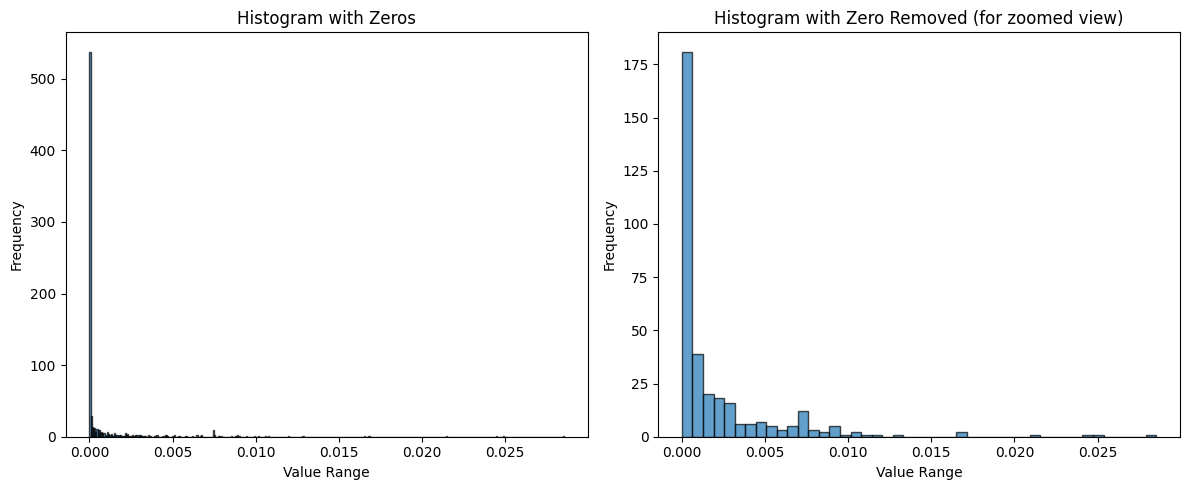

In [45]:

## Plotting the histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

trust_values = np.array(trust_values)
trust_values_non_zero = trust_values[trust_values>0]

axes[0].hist(trust_values, bins='auto', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Value Range')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram with Zeros')

axes[1].hist(trust_values_non_zero, bins='auto', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Value Range')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram with Zero Removed (for zoomed view)')

plt.tight_layout()
plt.savefig('Histogram.png')
plt.show()